
Deep Learning CS 6953 / ECE 7123 2025 Spring

Title - (Jailbreaking Deep Models: Adversarial Attacks on ResNet-34)


Author (Ajay Venkatesh, Shreyas Kootiganahalli Venugopal, Thejas Mandya Shashidhara)

**Task 1: Basics**

In [2]:
# Mount Google Drive to access the dataset and label mapping
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Libraries

This section imports all the necessary libraries required for building, training, and evaluating adversarial attacks on deep learning models:

- **torch**: Core PyTorch functionality.
- **torchvision**: Pretrained models and image processing utilities.
- **matplotlib** & **PIL**: For image visualization and manipulation.
- **json** & **os**: For file I/O and working with metadata (e.g., ImageNet class labels).

In [ ]:
# Standard imports for data loading, processing, model inference, and visualization
import os
import json
import numpy as np
import torch
import random
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn.functional as F

In [ ]:
# Set the computation device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# Load pretrained ResNet-34 model with ImageNet weights
resnet34 = torchvision.models.resnet34(weights='IMAGENET1K_V1')
resnet34.eval()
resnet34.to(device)

# Load the custom label mapping from Drive (contains ImageNet indices)
label_path = "/content/drive/MyDrive/TestDataSet/labels_list.json"
with open(label_path, "r") as f:
    labels = json.load(f)
# Extract integer class indices (e.g., 401, 402, ...) from the label entries
imagenet_indices = [int(entry.split(":")[0]) for entry in labels]

Using device: cuda


In [ ]:
# Define ImageNet standard normalization statistics
MEAN = np.array([0.485, 0.456, 0.406])
STD  = np.array([0.229, 0.224, 0.225])
# Compose preprocessing steps for the dataset
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

In [ ]:
# Set the path to the dataset directory in Google Drive
dataset_path = "/content/drive/MyDrive/TestDataSet"
# Load dataset using ImageFolder: assumes subfolders represent class labels
dataset = torchvision.datasets.ImageFolder(
    root=dataset_path,
    transform=plain_transforms
)
# Create a DataLoader to batch and iterate through the dataset
loader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

## Model Evaluation and Accuracy Calculation

This section performs inference and evaluates the pretrained ResNet-34 on the custom dataset:

- **Top-1 Accuracy**: Checks whether the model's most confident prediction matches the true label.
- **Top-5 Accuracy**: Checks whether the true label is among the model's five most confident predictions.
- **Target Offset (+401)**: This shift aligns your dataset's class indices with the ImageNet label space (since you're starting from class 401).

- **Evaluation Details**:
  - Gradients are disabled with `torch.no_grad()` to improve performance.
  - Uses `torch.topk` to extract top predictions.
  - Prints total samples processed and accuracy metrics.

In [ ]:
# Wrap dataset with DataLoader for batch processing
top1_correct = 0
top5_correct = 0
total = 0
# Turn off gradient calculations for evaluation (faster and less memory)
with torch.no_grad():
    for images, targets in tqdm(loader, desc="Evaluating batches"):
        images = images.to(device)
        targets = targets.to(device) + 401         # Adjust the ground truth targets by +401 bacause our dataset classes start from ImageNet index 401

        outputs = resnet34(images)
        _, top5 = outputs.topk(5, dim=1)
        top1 = top5[:, 0]

        top1_correct += (top1 == targets).sum().item()
        top5_correct += sum(targets[i] in top5[i] for i in range(len(targets)))
        total += targets.size(0)

top1_acc = top1_correct / total * 100
top5_acc = top5_correct / total * 100

# Final accuracy results
print(f"Total samples evaluated: {total}")
#Checks if the model's top prediction matches the ground truth label.
print(f"Top-1 Accuracy: {top1_acc:.2f}%")
#Checks if the true label is within the model's top 5 predictions
print(f"Top-5 Accuracy: {top5_acc:.2f}%")

Evaluating batches: 100%|██████████| 16/16 [03:04<00:00, 11.53s/it]

Total samples evaluated: 500
Top-1 Accuracy: 76.00%
Top-5 Accuracy: 94.20%


## Model & Transform Reinitialization

This cell reloads the ResNet-34 model and redefines essential transformations:

- **Model**: Reloaded and pushed to device again (possibly to avoid contamination from previous operations).
- **Labels**: Reloaded from the `labels_list.json`.
- **Transforms**:
  - `normalize`: Standard ImageNet input normalization.
  - `unnormalize`: Reverts normalization — useful for visualizing adversarial outputs.
  - `denormalize`: Alternative implementation using `zip()`.
  - `to_tensor`: Converts a PIL image to a PyTorch tensor.

In [ ]:
# Reload ResNet-34 model and prepare for inference
model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
model.eval()
model.to(device)
# Load label mapping again from JSON
json_path = "/content/drive/MyDrive/TestDataSet/labels_list.json"
with open(json_path, "r") as f:
    labels = json.load(f)
imagenet_indices = [int(x.split(":")[0]) for x in labels]

# Define normalization and unnormalization transformations
MEAN = np.array([0.485, 0.456, 0.406])
STD  = np.array([0.229, 0.224, 0.225])
normalize   = transforms.Normalize(mean=MEAN, std=STD)
unnormalize = transforms.Normalize(mean=-MEAN/STD, std=1/STD)

# Alternate denormalizer using zip
denormalize = transforms.Normalize(
    mean=[-m/s for m, s in zip(MEAN, STD)],
    std=[1/s for s in STD]
)
# Used to convert PIL Image to tensor
to_tensor   = transforms.ToTensor()

In [ ]:
EPSILON = 0.02
# Maximum allowed pixel perturbation for FGSM attack (L-infinity norm)


dataset_path = "/content/drive/MyDrive/TestDataSet"
dataset = torchvision.datasets.ImageFolder(root=dataset_path)
# Create a DataLoader with batch size 1 for generating adversarial examples one by one
loader = DataLoader(dataset, batch_size=1, shuffle=False)


adv_save_dir = "/content/drive/MyDrive/Adversarial_Test_Set_1"
os.makedirs(adv_save_dir, exist_ok=True)

##  FGSM Adversarial Attack Execution

This block performs a full **Fast Gradient Sign Method (FGSM)** attack:

- **Perturbation**: Adds a small, signed gradient-scaled noise to input images (`ε = 0.02`).
- **Goal**: Generate adversarial samples that visually look the same but fool the classifier.
- **Outputs**:
  - Adversarial images are saved to disk (`adv_XXXX.png`).
  - Top-1 predictions are recorded for comparison.
  - L-infinity distance (max pixel change) is tracked for each image.

The attack succeeds if the model’s top-1 prediction changes for the perturbed image.

In [ ]:
# Lists to store results and metrics
adv_images = []
orig_images = []
true_labels  = []
adv_labels   = []
linf_distances = []

print("Running FGSM attack on dataset...")

for i, (img_pil, label) in enumerate(tqdm(dataset, desc="FGSM")):
    raw = to_tensor(img_pil).unsqueeze(0).to(device)
    raw.requires_grad_(True)
    label = label + 401

    normed = normalize(raw)
    logits = model(normed)

    target_tensor = torch.tensor([label], device=device) # Compute loss and gradients
    loss = torch.nn.functional.cross_entropy(logits, target_tensor)

    model.zero_grad()
    loss.backward()
     # Generate adversarial image using sign of gradient (FGSM step)
    sign_grad = raw.grad.sign()
    adv_raw = torch.clamp(raw + EPSILON * sign_grad, 0, 1)
    adv_norm = normalize(adv_raw)

    save_path = os.path.join(adv_save_dir, f"adv_{i:04d}.png")
    save_image(adv_raw.squeeze().cpu(), save_path)
    # Run model on adversarial image to get prediction
    with torch.no_grad():
        pred_logits = model(adv_norm)
        pred_top1 = pred_logits.argmax(dim=1).item()
    # Save visual and label results
    orig_images.append(normed[0].cpu())
    adv_images.append(adv_norm[0].cpu())
    true_labels.append(label)
    adv_labels.append(pred_top1)
    # Calculate and store max L-infinity norm distance
    linf = torch.max(torch.abs(adv_raw - raw)).item()
    linf_distances.append(linf)

print(" FGSM adversarial images generated.")

# Report max perturbation strength applied
max_linf = max(linf_distances)
print(f"\n  MAX L∞ distance: {max_linf:.6f}")

Running FGSM attack on dataset...


FGSM: 100%|██████████| 500/500 [00:24<00:00, 20.49it/s]

✔️ FGSM adversarial images generated.

📐 MAX L∞ distance: 0.020000


## Visualizing FGSM Adversarial Examples

This section visualizes 5 randomly chosen **misclassified** samples after FGSM attack.

For each image:
- **Original Image**: Before the attack, with its true label and original prediction.
- **Adversarial Image**: After the FGSM perturbation.
- **Noise (Scaled)**: Shows the adversarial perturbation applied, normalized to [0, 1].
- **Top-5 Predictions**: Bar plot showing the model's top-5 class predictions and their confidence scores for the adversarial image.

This visualization helps assess how subtle perturbations can cause drastic prediction shifts.


🎨 Enhanced visualization for 5 random misclassified samples...


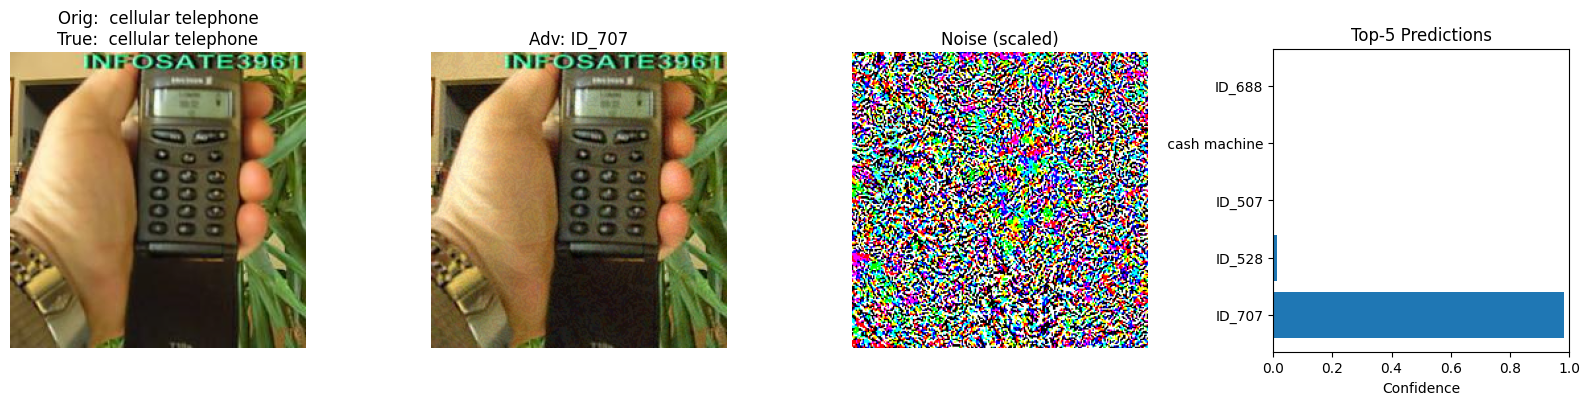

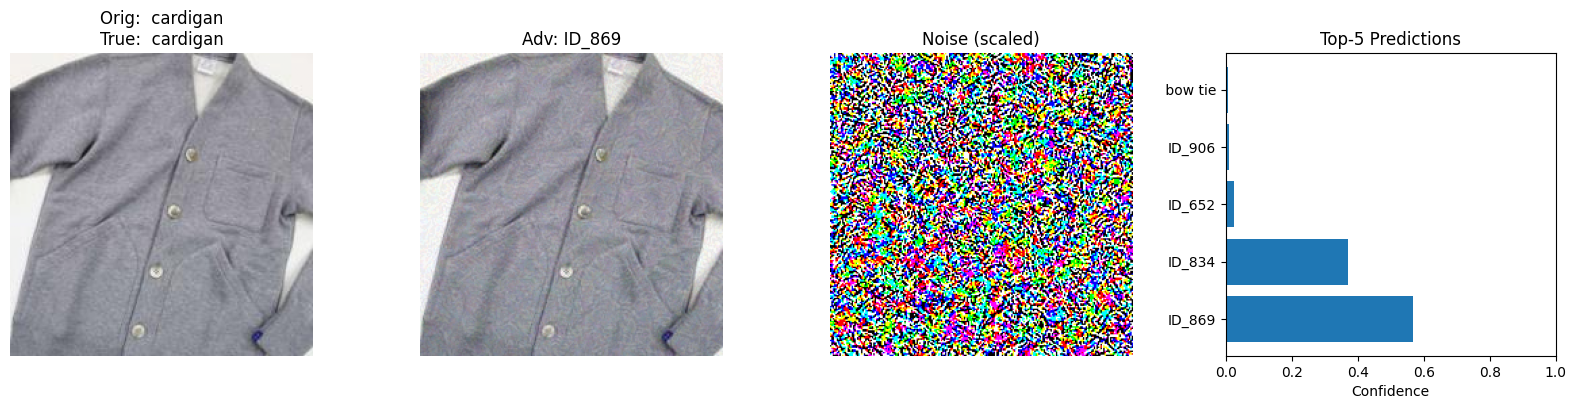

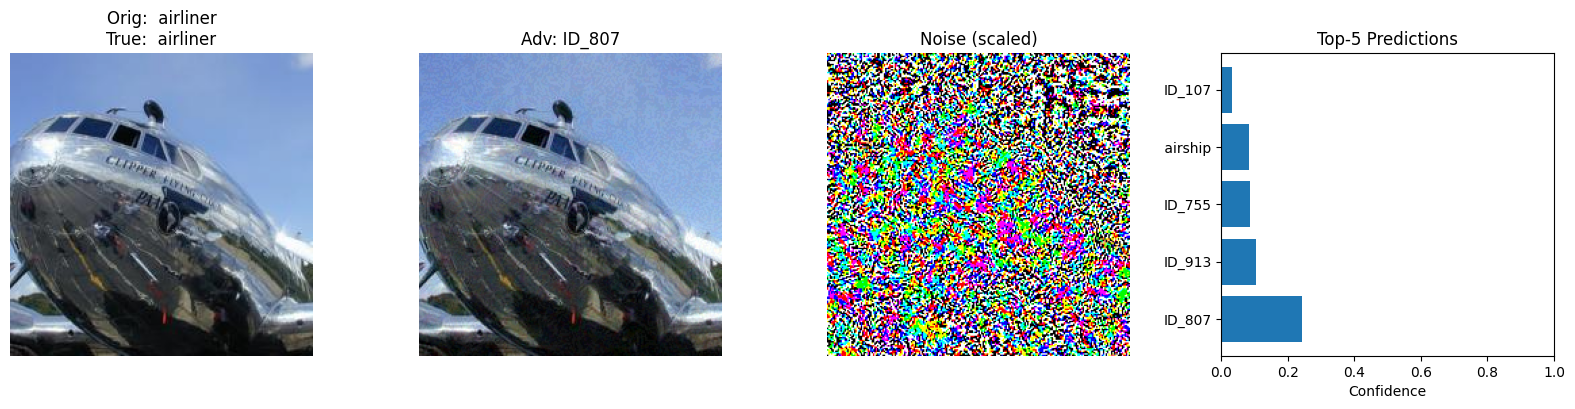

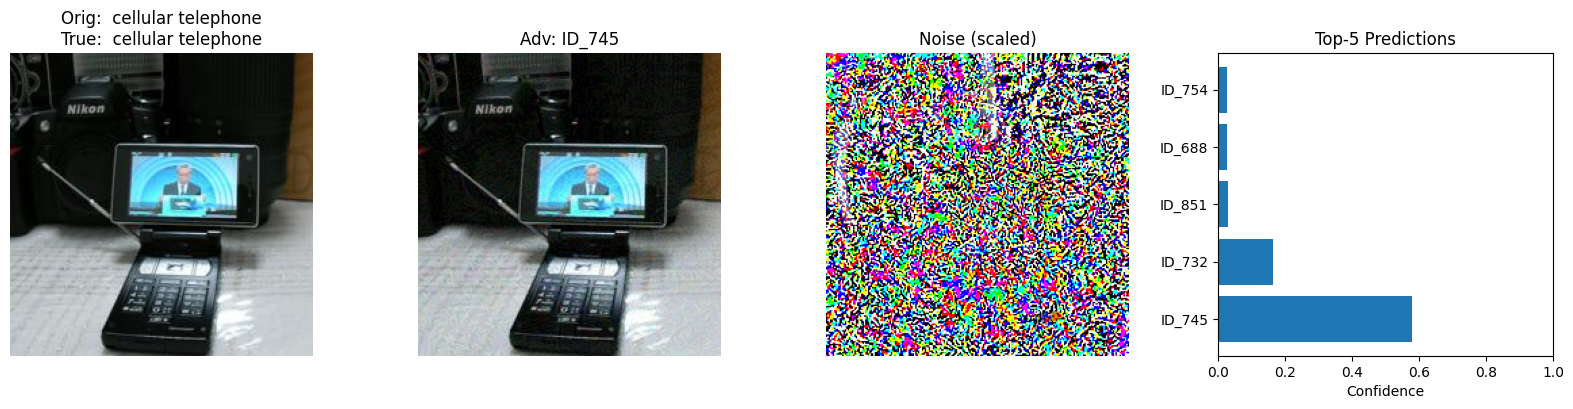

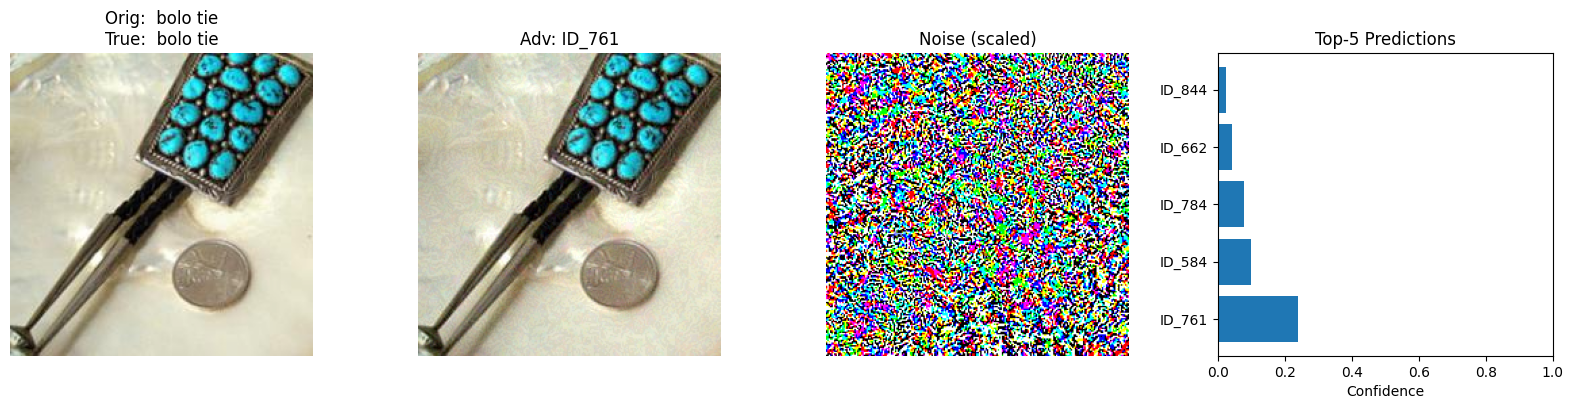

In [ ]:
true_labels = torch.tensor(true_labels)
adv_labels = torch.tensor(adv_labels)

misclassified = (true_labels != adv_labels).nonzero(as_tuple=True)[0] # Find misclassified samples
print(f"\n  Enhanced visualization for {min(5, len(misclassified))} random misclassified samples...")

# Convert label list into a dictionary: {index: class_name}
label_dict = {int(entry.split(":")[0]): entry.split(":")[1] for entry in labels}

# Select 5 random misclassified indices
import random
random_misclassified = random.sample(misclassified.tolist(), k=min(5, len(misclassified)))


# Loop through selected samples
for idx in random_misclassified:
    orig_tensor = orig_images[idx]
    adv_tensor  = adv_images[idx]

    # Convert tensors to denormalized numpy images
    orig_img = denormalize(orig_tensor).permute(1, 2, 0).detach().clamp(0, 1).cpu().numpy()
    adv_img  = denormalize(adv_tensor).permute(1, 2, 0).detach().clamp(0, 1).cpu().numpy()
    # Compute and normalize perturbation (noise)
    noise    = (adv_tensor - orig_tensor).cpu()
    noise_vis = (noise - noise.min()) / (noise.max() - noise.min() + 1e-8)
    noise_vis = noise_vis.permute(1, 2, 0).detach().numpy().clip(0, 1)

    # Get top-5 predictions for adversarial sample
    with torch.no_grad():
        logits = model(adv_tensor.unsqueeze(0).to(device))
        probs  = F.softmax(logits, dim=1)[0].cpu().numpy()
        top5_idx = np.argsort(probs)[-5:][::-1]
        top5_probs = probs[top5_idx]
        top5_labels = [label_dict.get(i, f"ID_{i}") for i in top5_idx]

    true_label_name = label_dict.get(true_labels[idx].item(), f"ID_{true_labels[idx].item()}")
    adv_pred_name = label_dict.get(adv_labels[idx].item(), f"ID_{adv_labels[idx].item()}")
    orig_pred_name = label_dict.get(model(orig_tensor.unsqueeze(0).to(device)).argmax().item(), "Unknown")

    # Plot layout
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    axes[0].imshow(orig_img)
    axes[0].set_title(f"Orig: {orig_pred_name}\nTrue: {true_label_name}")
    axes[0].axis("off")

    axes[1].imshow(adv_img)
    axes[1].set_title(f"Adv: {adv_pred_name}")
    axes[1].axis("off")

    axes[2].imshow(noise_vis)
    axes[2].set_title("Noise (scaled)")
    axes[2].axis("off")

    y = np.arange(5)[::-1]
    axes[3].barh(y, top5_probs[::-1])
    axes[3].set_yticks(y)
    axes[3].set_yticklabels(top5_labels[::-1])
    axes[3].set_xlim(0, 1.0)
    axes[3].set_xlabel("Confidence")
    axes[3].set_title("Top-5 Predictions")

    plt.tight_layout()
    plt.show()

## FGSM Evaluation Accuracy

This block measures how much the FGSM adversarial attack reduced model performance:

- **Top-1 Accuracy**: Fraction of adversarial examples where the top prediction was still correct.
- **Top-5 Accuracy**: Fraction where the correct class appeared in the top 5 predictions.
- Accuracy is computed in batches of 32 for efficiency.

This helps quantify the **success rate** of the adversarial attack in fooling the model.

In [ ]:
print("\n  Evaluating adversarial accuracy...")
top1_corr = top5_corr = total = 0

model.eval()
with torch.no_grad():
    for start in range(0, len(adv_images), 32):
        # Stack 32 adversarial images into a batc
        batch = torch.stack(adv_images[start:start+32]).to(device)
        targets = true_labels[start:start+32].to(device)
        # Forward pass
        outputs = model(batch)
        # Top-5 predictions
        _, top5 = outputs.topk(5, dim=1)
        top1 = top5[:, 0]
        # Accuracy calculation
        top1_corr += (top1 == targets).sum().item()
        top5_corr += sum(targets[j].item() in top5[j] for j in range(len(targets)))
        total += targets.size(0)

adv_top1_acc = top1_corr / total * 100
adv_top5_acc = top5_corr / total * 100
# Report accuracy on adversarial set
print(f"\n FGSM Evaluation (ε={EPSILON}):")
print(f"Top-1 Accuracy: {adv_top1_acc:.2f}%")
print(f"Top-5 Accuracy: {adv_top5_acc:.2f}%")


📊 Evaluating adversarial accuracy...

 FGSM Evaluation (ε=0.02):
Top-1 Accuracy: 3.60%
Top-5 Accuracy: 20.80%


## PGD Attack Setup

This section initializes parameters and directories for the **Projected Gradient Descent (PGD)** attack:

- `EPSILON = 0.02`: Maximum total perturbation.
- `ALPHA = 0.001`: Step size for each gradient update.
- `NUM_ITER = 10`: Number of iterations.
- The dataset is reloaded without transforms to preserve original image quality.
- A new folder `Adversarial_Test_Set_2` is created in Drive to save PGD-generated adversarial samples.

PGD is a **stronger iterative attack** compared to FGSM, making it more effective at deceiving deep networks.

In [ ]:
EPSILON  = 0.02
ALPHA    = 0.001
NUM_ITER = 10

# Load original dataset again without transforms to retain raw PIL images
root = "/content/drive/MyDrive/TestDataSet"
# Use ImageFolder without transforms to get raw PIL images and labels
dataset = torchvision.datasets.ImageFolder(root=root)
loader = DataLoader(dataset, batch_size=1, shuffle=False)
# Directory to save PGD adversarial images
adv_save_dir2 = "/content/drive/MyDrive/Adversarial_Test_Set_2"
os.makedirs(adv_save_dir2, exist_ok=True)

## PGD Adversarial Attack Execution

This block performs the **Projected Gradient Descent (PGD)** attack:

- **Objective**: Apply small, iterative FGSM-like perturbations to deceive the model.
- **Projection**: After each update, the image is re-projected into the ε-ball around the original image.
- **Key Steps**:
  - Normalize each step before feeding into the model.
  - Compute gradients using cross-entropy loss.
  - Save the resulting adversarial image (`adv_XXXX.png`).
  - Record Top-1 prediction and L∞ distance.

This iterative method is stronger than FGSM and aims to more effectively fool the network.

In [ ]:
# Lists to store tensors and labels for later evaluation
adv_images_pgd      = []
orig_images_pgd     = []
true_labels_pgd     = []
adv_labels_pgd      = []
linf_distances_pgd  = []

print("Running PGD attack on dataset...")
# Iterate over each image in the dataset
for i, (img_pil, label) in enumerate(tqdm(dataset, desc="PGD Attack")):

    raw = to_tensor(img_pil).unsqueeze(0).to(device)
    orig_tensor = raw.clone().detach()
    label=label+401

    perturbed = orig_tensor.clone().detach()
    perturbed.requires_grad_(True)
    # PGD loop: apply small FGSM steps and project back
    for _ in range(NUM_ITER):

        normed = normalize(perturbed)
        logits = model(normed)

        target_tensor = torch.tensor([label], device=device)
        loss = torch.nn.functional.cross_entropy(logits, target_tensor)

        model.zero_grad()
        loss.backward()

        step = ALPHA * perturbed.grad.sign()
        perturbed_data = perturbed + step
        # Project perturbation back into ε-ball
        delta = torch.clamp(perturbed_data - orig_tensor,
                            min=-EPSILON, max=EPSILON)
        perturbed = torch.clamp(orig_tensor + delta, 0, 1).detach()
        perturbed.requires_grad_(True)
    # Normalize the final perturbed image for inference
    adv_norm = normalize(perturbed)

    save_path = os.path.join(adv_save_dir2, f"adv_{i:04d}.png")
    save_image(perturbed.squeeze().cpu(), save_path)

    with torch.no_grad():
        pred_logits = model(adv_norm)

        pred_top1 = pred_logits.argmax(dim=1).item()

    orig_images_pgd.append(normalize(orig_tensor.squeeze()).cpu())
    adv_images_pgd.append(adv_norm.squeeze().cpu())
    true_labels_pgd.append(label)
    adv_labels_pgd.append(pred_top1)
    # Compute L-infinity distance
    linf = torch.max(torch.abs(perturbed - raw)).item()
    linf_distances_pgd.append(linf)

print(" PGD adversarial images generated.")

Running PGD attack on dataset...


PGD Attack: 100%|██████████| 500/500 [01:32<00:00,  5.40it/s]

✔️ PGD adversarial images generated.


In [ ]:
# Calculate the maximum L-infinity norm of the perturbation across all PGD samples
max_linf = max(linf_distances_pgd)
print(f"\n  MAX L∞ distance: {max_linf:.6f}")


📐 MAX L∞ distance: 0.010000


## Visualizing PGD Misclassifications

This section shows detailed results for **5 random PGD-misclassified samples**:

- **Original Image** with true and predicted labels.
- **Adversarial Image** post PGD attack.
- **Noise Map** showing scaled perturbation difference.
- **Top-5 Predictions Bar Plot** showing model confidence for top predictions.

This visualization helps analyze the **subtle yet impactful** nature of PGD perturbations.


🎨 Enhanced visualization for random PGD misclassified samples...


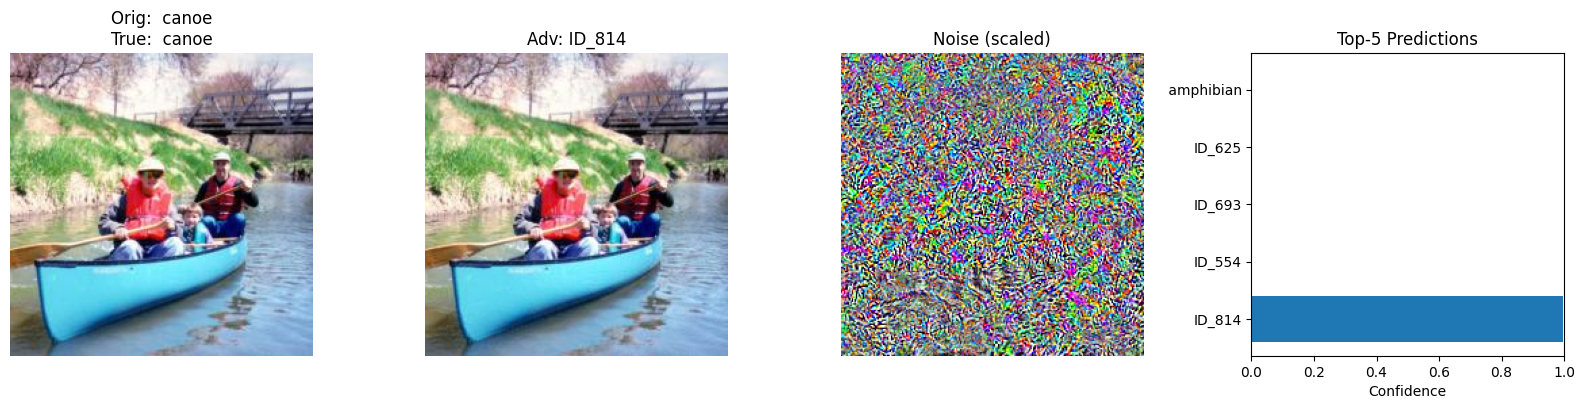

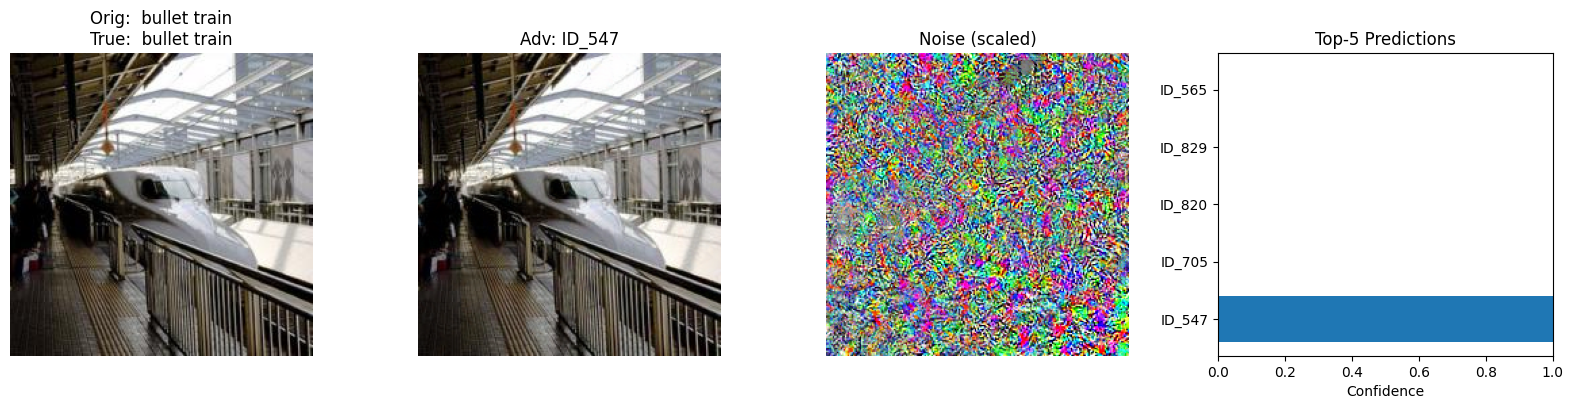

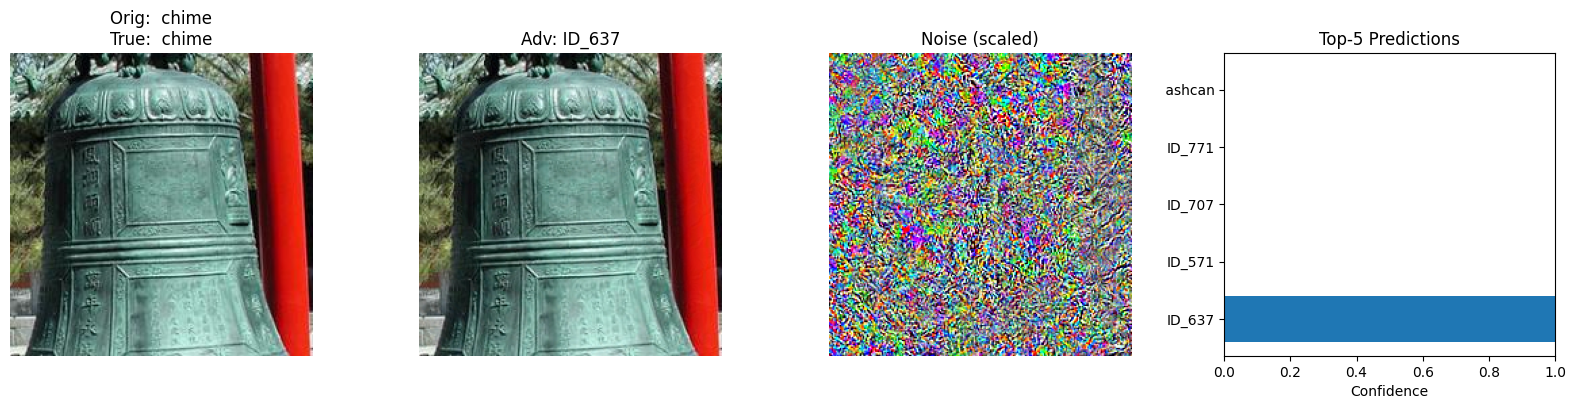

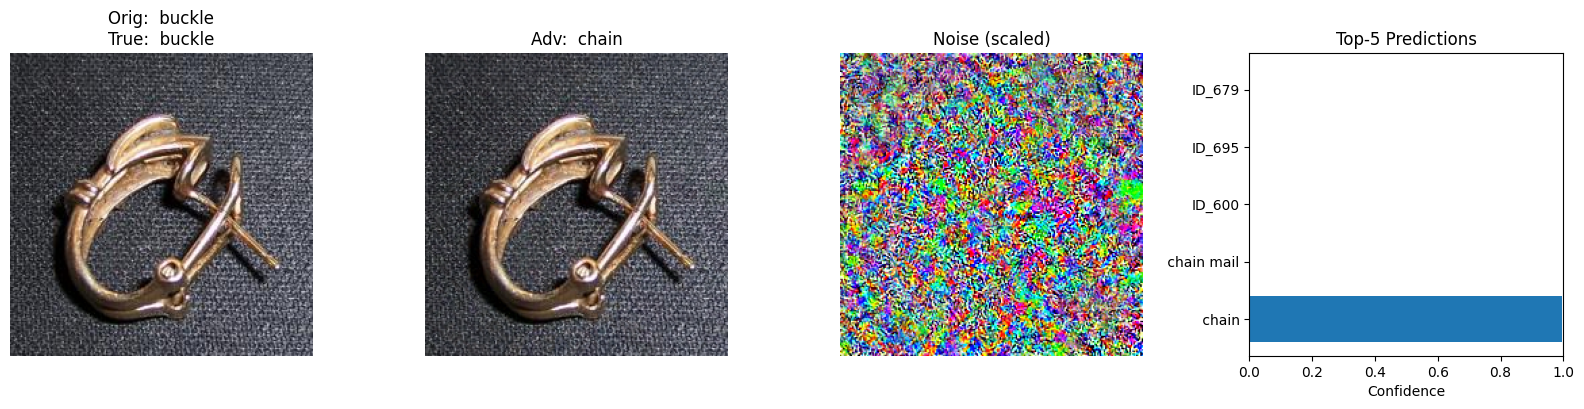

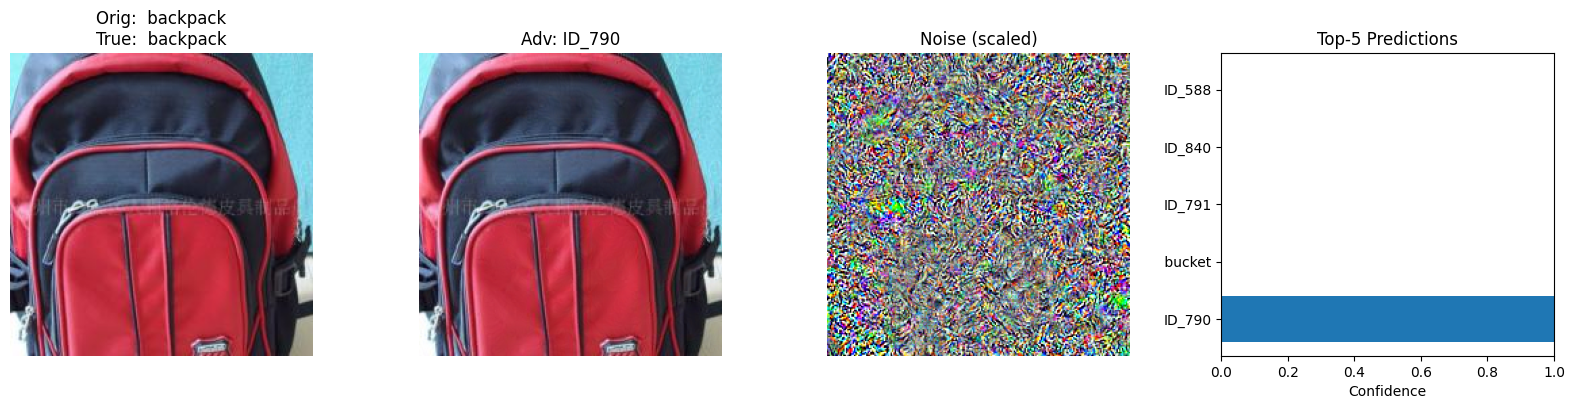

In [ ]:
print("\n  Enhanced visualization for random PGD misclassified samples...")

# Stack saved PGD images and convert labels to tensors
orig_images_pgd = torch.stack(orig_images_pgd)
adv_images_pgd  = torch.stack(adv_images_pgd)
true_labels_pgd = torch.tensor(true_labels_pgd)
adv_labels_pgd  = torch.tensor(adv_labels_pgd)

# Load label names from JSON list
label_dict = {int(entry.split(":")[0]): entry.split(":")[1] for entry in labels}

# Identify indices of PGD samples that were misclassified
mis_idx = (adv_labels_pgd != true_labels_pgd).nonzero(as_tuple=True)[0]


random_misclassified = random.sample(mis_idx.tolist(), k=min(5, len(mis_idx)))
# Visualize each selected misclassified sample
for idx in random_misclassified:
    orig_tensor = orig_images_pgd[idx]
    adv_tensor  = adv_images_pgd[idx]

    orig_img = denormalize(orig_tensor).permute(1, 2, 0).clamp(0, 1).detach().cpu().numpy()
    adv_img  = denormalize(adv_tensor).permute(1, 2, 0).clamp(0, 1).detach().cpu().numpy()
    # Compute perturbation visualization
    noise    = (adv_tensor - orig_tensor).cpu()
    noise_vis = (noise - noise.min()) / (noise.max() - noise.min() + 1e-8)
    noise_vis = noise_vis.permute(1, 2, 0).detach().numpy().clip(0, 1)

    # Get top-5 predictions for adversarial image
    with torch.no_grad():
        logits = model(adv_tensor.unsqueeze(0).to(device))
        probs  = F.softmax(logits, dim=1)[0].cpu().numpy()
        top5_idx = np.argsort(probs)[-5:][::-1]
        top5_probs = probs[top5_idx]
        top5_labels = [label_dict.get(i, f"ID_{i}") for i in top5_idx]

    true_label_name = label_dict.get(true_labels_pgd[idx].item(), f"ID_{true_labels_pgd[idx].item()}")
    adv_pred_name = label_dict.get(adv_labels_pgd[idx].item(), f"ID_{adv_labels_pgd[idx].item()}")
    orig_pred_name = label_dict.get(model(orig_tensor.unsqueeze(0).to(device)).argmax().item(), "Unknown")

    # Plot 4-pane view: Original, Adversarial, Noise, Top-5 Bar Chart
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    axes[0].imshow(orig_img)
    axes[0].set_title(f"Orig: {orig_pred_name}\nTrue: {true_label_name}")
    axes[0].axis("off")

    axes[1].imshow(adv_img)
    axes[1].set_title(f"Adv: {adv_pred_name}")
    axes[1].axis("off")

    axes[2].imshow(noise_vis)
    axes[2].set_title("Noise (scaled)")
    axes[2].axis("off")

    y = np.arange(5)[::-1]
    axes[3].barh(y, top5_probs[::-1])
    axes[3].set_yticks(y)
    axes[3].set_yticklabels(top5_labels[::-1])
    axes[3].set_xlim(0, 1.0)
    axes[3].set_xlabel("Confidence")
    axes[3].set_title("Top-5 Predictions")

    plt.tight_layout()
    plt.show()

In [ ]:
print("\n Evaluating accuracy on PGD adversarial set...")
top1_corr = top5_corr = total = 0

model.eval()
with torch.no_grad():
    for start in range(0, len(adv_images_pgd), 32):
        # Create a batch of adversarial images and labels
        batch   = adv_images_pgd[start:start+32].to(device)
        targets = true_labels_pgd[start:start+32].to(device)

        outputs = model(batch)
        # Get Top-1 and Top-5 predictions
        _, top5 = outputs.topk(5, dim=1)
        top1   = top5[:,0]

        top1_corr += (top1 == targets).sum().item()
        top5_corr += sum(targets[j].item() in top5[j] for j in range(len(top5)))
        total     += targets.size(0)

adv_top1_acc_pgd = top1_corr / total * 100
adv_top5_acc_pgd = top5_corr / total * 100

print(f"\n✅ PGD Evaluation (ε={EPSILON}, α={ALPHA}, iter={NUM_ITER}):")
print(f"Top-1 Accuracy: {adv_top1_acc_pgd:.2f}%")
print(f"Top-5 Accuracy: {adv_top5_acc_pgd:.2f}%")


📊 Evaluating accuracy on PGD adversarial set...

✅ PGD Evaluation (ε=0.02, α=0.001, iter=10):
Top-1 Accuracy: 0.00%
Top-5 Accuracy: 4.20%


## 📈 PGD Iteration Sweep

This experiment plots how increasing the number of PGD iterations affects Top‑1 and Top‑5 accuracy.

PGD (10 iters): 100%|██████████| 500/500 [01:16<00:00,  6.54it/s]


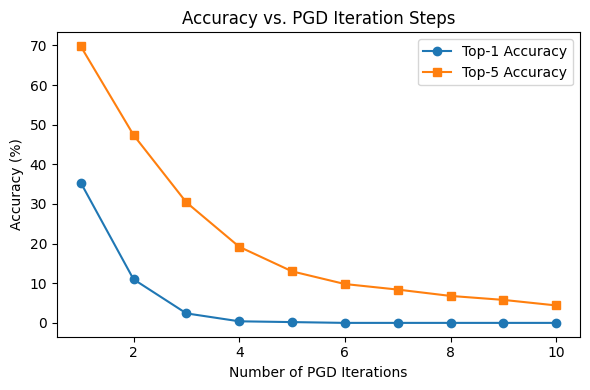

In [ ]:
# Sweep PGD iterations from 1 to NUM_ITER (10) and record Top-1/Top-5 accuracy
iter_steps    = list(range(1, NUM_ITER+1))
top1_acc_list = []
top5_acc_list = []

for num_steps in iter_steps:
    top1_corr = 0
    top5_corr = 0
    total     = len(dataset)


    for img_pil, label in tqdm(dataset, desc=f"PGD ({num_steps} iters)"):

        raw       = to_tensor(img_pil).unsqueeze(0).to(device)
        orig      = raw.detach().clone()
        perturbed = orig.clone().detach().requires_grad_(True)
        label=label+401


        for _ in range(num_steps):
            normed = normalize(perturbed)
            logits = model(normed)

            loss   = torch.nn.functional.cross_entropy(logits, torch.tensor([label], device=device))
            model.zero_grad(); loss.backward()

            step   = ALPHA * perturbed.grad.sign()
            updated= perturbed + step
            delta  = torch.clamp(updated - orig, -EPSILON, EPSILON)
            perturbed = torch.clamp(orig + delta, 0, 1).detach().requires_grad_(True)


        with torch.no_grad():
            pred=model(normalize(perturbed))

            _, top5 = pred.topk(5, dim=1)
            pred1 = top5[:,0].item()


        if pred1 == label:
            top1_corr += 1
        if label in top5[0].tolist():
            top5_corr += 1

    top1_acc_list.append(100 * top1_corr / total)
    top5_acc_list.append(100 * top5_corr / total)

# Plot accuracy vs. number of PGD iterations
plt.figure(figsize=(6,4))
plt.plot(iter_steps, top1_acc_list, marker='o', label="Top‑1 Accuracy")
plt.plot(iter_steps, top5_acc_list, marker='s', label="Top‑5 Accuracy")
plt.xlabel("Number of PGD Iterations")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs. PGD Iteration Steps")
plt.legend()
plt.tight_layout()
plt.show()

**Task 4: Patch attacks**

## Patch PGD Setup

Initializes configuration for a PGD-based attack constrained to a 32×32 patch region.

In [ ]:
EPSILON    = 0.48
ALPHA      = 0.05
NUM_ITER   = 100
PATCH_SIZE = 32

# Load raw dataset again (PIL format)
root = "/content/drive/MyDrive/TestDataSet"
dataset = torchvision.datasets.ImageFolder(root=root)
# Directory to save patch-based adversarial samples
adv_save_dir3 = "/content/drive/MyDrive/Adversarial_Test_Set_3"
os.makedirs(adv_save_dir3, exist_ok=True)

## Patch-Based PGD Attack

This block applies PGD only within a randomly selected 32×32 region per image:

- Perturbations are constrained to the patch area.
- Helps simulate **localized adversarial attacks** (e.g., stickers or tampering).
- Results are saved and predictions recorded for later evaluation.

In [ ]:
# Lists to accumulate evaluation metrics and visuals
adv_images_patch     = []
orig_images_patch    = []
true_labels_patch    = []
adv_labels_patch     = []
linf_distances_patch = []

print("🚨 Running Patch-PGD attack on dataset...")

for i, (img_pil, label) in enumerate(tqdm(dataset, desc="Patch-PGD")):

    raw = to_tensor(img_pil).unsqueeze(0).to(device)
    orig = raw.clone().detach()
    label=label+401

    # Start with a clean image for perturbation
    perturbed = orig.clone().detach()
    perturbed.requires_grad_(True)

    # Randomly choose top-left corner for the patch
    _, _, H, W = raw.shape
    top  = np.random.randint(0, H - PATCH_SIZE + 1)
    left = np.random.randint(0, W - PATCH_SIZE + 1)

    # Perform PGD within the patch for NUM_ITER steps
    for _ in range(NUM_ITER):

        normed = normalize(perturbed)
        logits = model(normed)

        target_tensor = torch.tensor([label], device=device)
        loss = torch.nn.functional.cross_entropy(logits, target_tensor)

        model.zero_grad()
        loss.backward()

        grad = perturbed.grad.data
        patch_grad = torch.zeros_like(grad)
        patch_grad[:, :, top:top+PATCH_SIZE, left:left+PATCH_SIZE] = \
            grad[:, :, top:top+PATCH_SIZE, left:left+PATCH_SIZE]

        updated = perturbed + ALPHA * patch_grad.sign()
        delta = torch.clamp(updated - orig, min=-EPSILON, max=EPSILON)
        perturbed = torch.clamp(orig + delta, 0, 1).detach()
        perturbed.requires_grad_(True)

    # Normalize final perturbed image for inference
    adv_norm = normalize(perturbed)

    # Save the adversarial image to disk (denormalized)
    save_path = os.path.join(adv_save_dir3, f"adv_patch_{i:04d}.png")
    save_image(perturbed.squeeze().cpu(), save_path)

    # Model prediction on final adversarial image
    with torch.no_grad():
        pred_logits = model(adv_norm)
        pred_top1   = pred_logits.argmax(dim=1).item()
    orig_images_patch.append(normalize(orig).squeeze(0).cpu())
    adv_images_patch.append(adv_norm.squeeze(0).cpu())
    true_labels_patch.append(label)
    adv_labels_patch.append(pred_top1)

    # Compute L∞ norm of perturbation
    linf = torch.max(torch.abs(perturbed - raw)).item()
    linf_distances_patch.append(linf)

print("✔️ Patch-based PGD adversarial images generated.")

🚨 Running Patch-PGD attack on dataset...


Patch-PGD: 100%|██████████| 500/500 [12:24<00:00,  1.49s/it]

✔️ Patch-based PGD adversarial images generated.


In [ ]:
# Compute the maximum pixel change (L-infinity distance) from all patch attacks
max_linf = max(linf_distances_patch)
print(f"\n Max L∞ Distance from Patch Attack: {max_linf:.6f}")


 Max L∞ Distance from Patch Attack: 0.480000


## Patch Attack Visualizations

Displays 5 random misclassified examples after the patch-based PGD attack. Each includes:
- Original and adversarial images.
- Perturbation heatmap.
- Model's top-5 predictions with confidence scores.


 Enhanced visualization for random Patch-PGD misclassified samples...


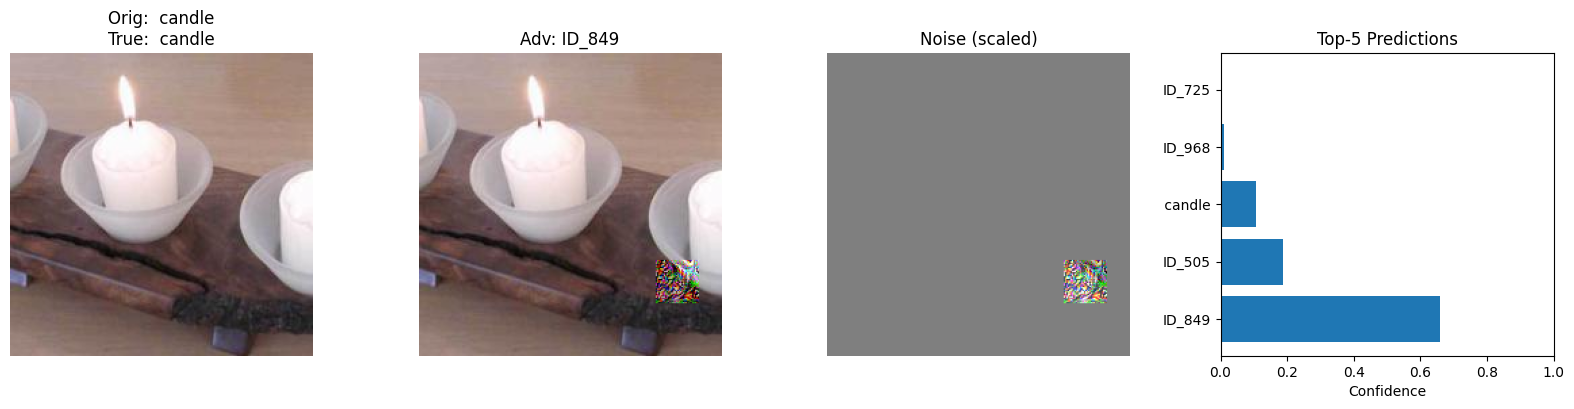

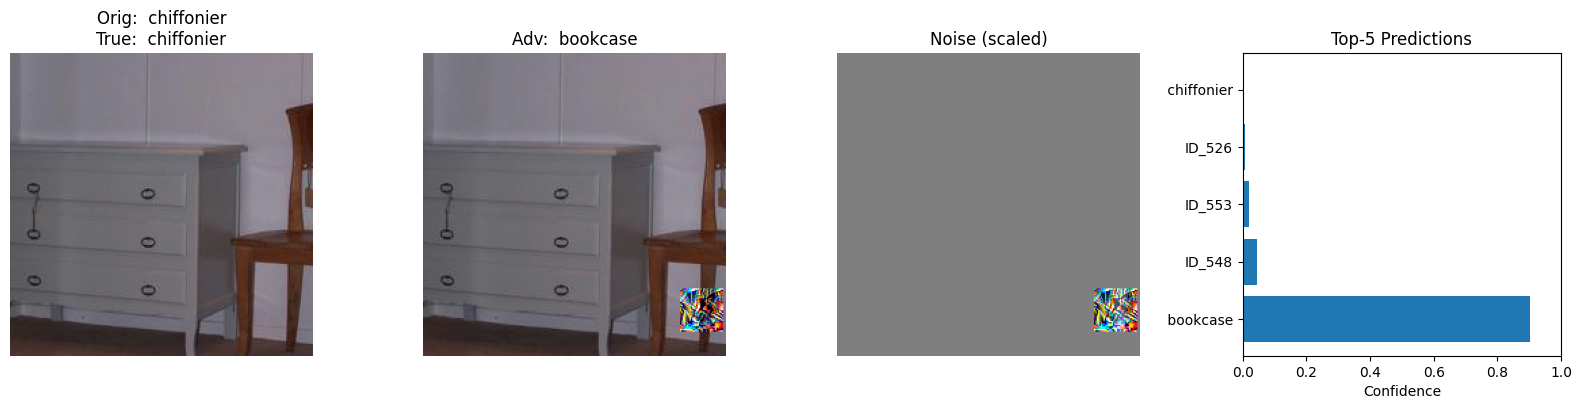

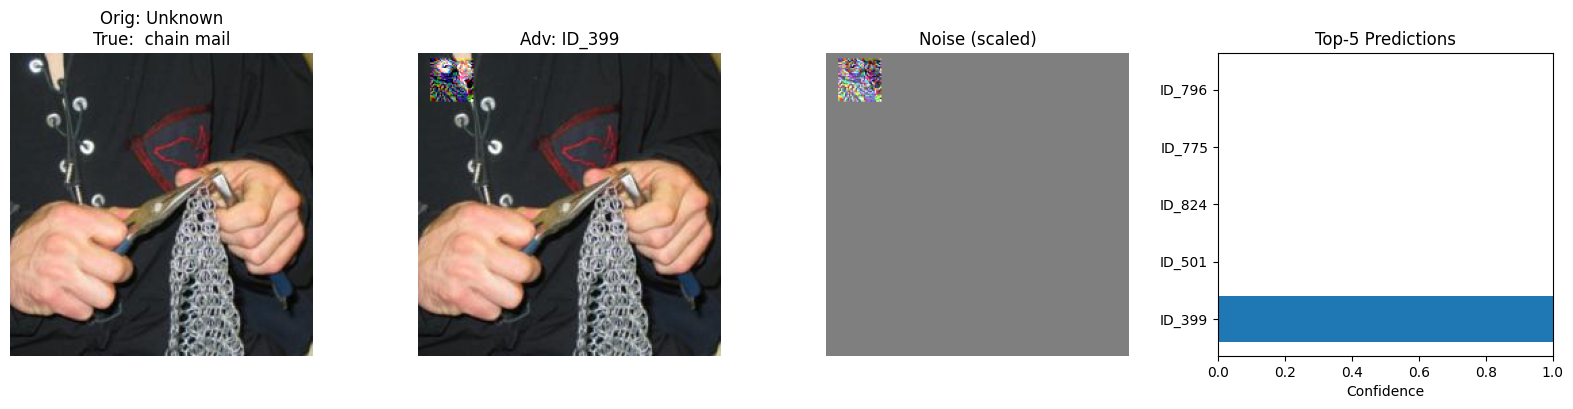

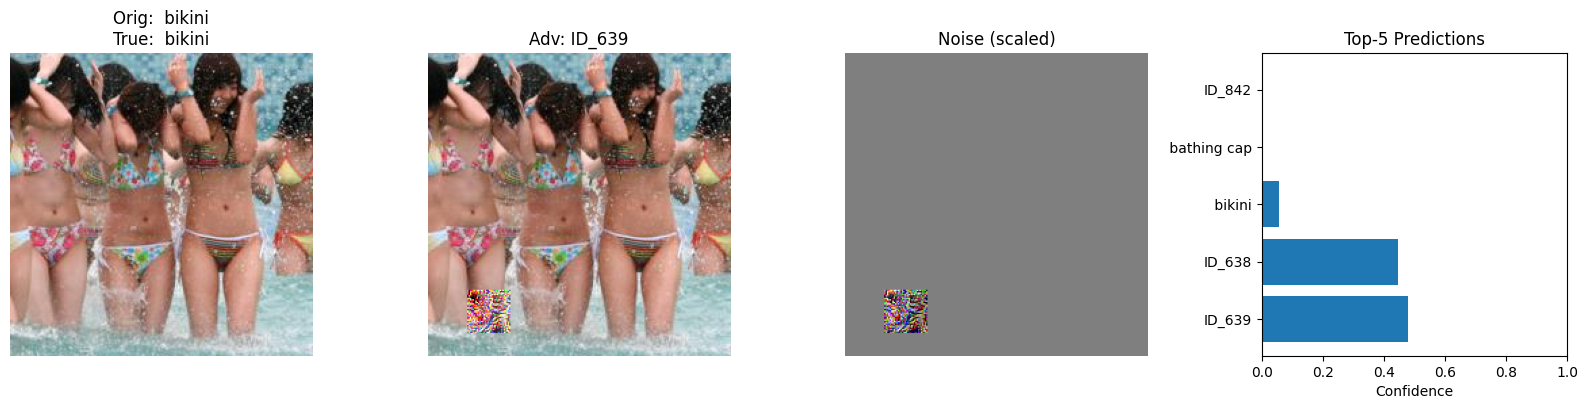

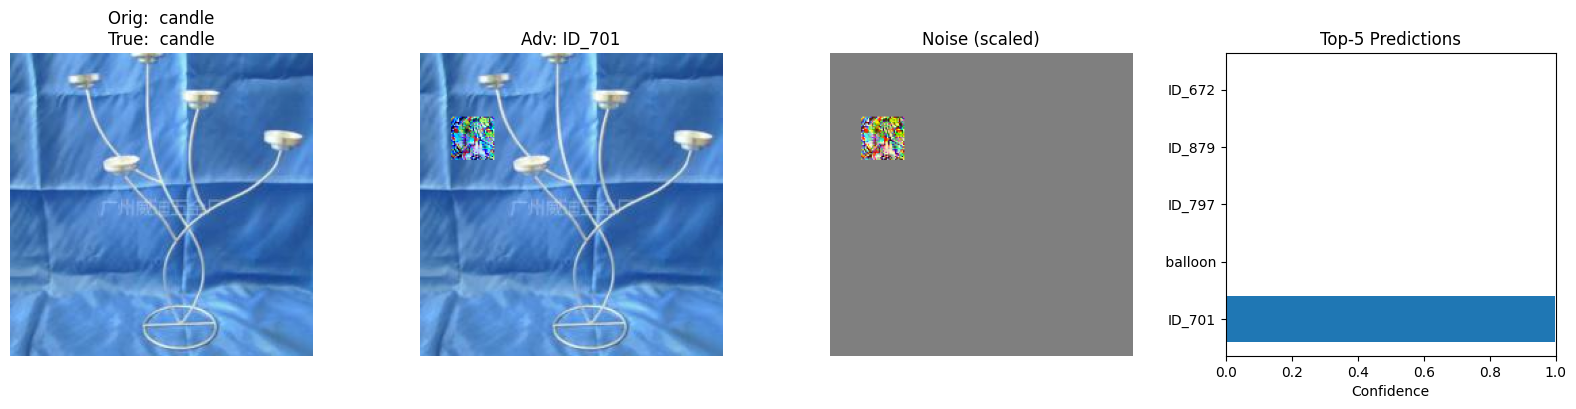

In [ ]:
print("\n Enhanced visualization for random Patch-PGD misclassified samples...")

# Stack tensors for processing and convert labels to tensors
orig_images_patch = torch.stack(orig_images_patch)
adv_images_patch  = torch.stack(adv_images_patch)
true_labels_patch = torch.tensor(true_labels_patch)
adv_labels_patch  = torch.tensor(adv_labels_patch)

# Load label mapping dictionary from `labels` list
label_dict = {int(entry.split(":")[0]): entry.split(":")[1] for entry in labels}

# Identify misclassified indices
mis_idx = (adv_labels_patch != true_labels_patch).nonzero(as_tuple=True)[0]
import random
random_misclassified = random.sample(mis_idx.tolist(), k=min(5, len(mis_idx)))
# Visualize each selected misclassified sample
for idx in random_misclassified:
    orig_tensor = orig_images_patch[idx]
    adv_tensor  = adv_images_patch[idx]

    # Denormalize and convert to numpy for plotting
    orig_img = denormalize(orig_tensor).permute(1, 2, 0).clamp(0, 1).detach().cpu().numpy()
    adv_img  = denormalize(adv_tensor).permute(1, 2, 0).clamp(0, 1).detach().cpu().numpy()
    # Compute and normalize perturbation for visualization
    noise    = (adv_tensor - orig_tensor).cpu()
    noise_vis = (noise - noise.min()) / (noise.max() - noise.min() + 1e-8)
    noise_vis = noise_vis.permute(1, 2, 0).detach().numpy().clip(0, 1)

    # Predict top-5 classes for adversarial image
    with torch.no_grad():
        logits = model(adv_tensor.unsqueeze(0).to(device))
        probs  = F.softmax(logits, dim=1)[0].cpu().numpy()
        top5_idx = np.argsort(probs)[-5:][::-1]
        top5_probs = probs[top5_idx]
        top5_labels = [label_dict.get(i, f"ID_{i}") for i in top5_idx]
    # Get human-readable labels
    true_label_name = label_dict.get(true_labels_patch[idx].item(), f"ID_{true_labels_patch[idx].item()}")
    adv_pred_name = label_dict.get(adv_labels_patch[idx].item(), f"ID_{adv_labels_patch[idx].item()}")
    orig_pred_name = label_dict.get(model(orig_tensor.unsqueeze(0).to(device)).argmax().item(), "Unknown")

    # Create 4-panel visualization
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    axes[0].imshow(orig_img)
    axes[0].set_title(f"Orig: {orig_pred_name}\nTrue: {true_label_name}")
    axes[0].axis("off")

    axes[1].imshow(adv_img)
    axes[1].set_title(f"Adv: {adv_pred_name}")
    axes[1].axis("off")

    axes[2].imshow(noise_vis)
    axes[2].set_title("Noise (scaled)")
    axes[2].axis("off")

    y = np.arange(5)[::-1]
    axes[3].barh(y, top5_probs[::-1])
    axes[3].set_yticks(y)
    axes[3].set_yticklabels(top5_labels[::-1])
    axes[3].set_xlim(0, 1.0)
    axes[3].set_xlabel("Confidence")
    axes[3].set_title("Top-5 Predictions")

    plt.tight_layout()
    plt.show()

## Patch Attack Evaluation

Measures Top-1 and Top-5 accuracy on adversarial images created using Patch-PGD attack.

In [ ]:
print("\n Evaluating accuracy on Patch-based PGD set...")
top1_corr = top5_corr = total = 0 # Initialize counters

model.eval()
with torch.no_grad():
    for start in range(0, len(adv_images_patch), 32):
        batch   = adv_images_patch[start:start+32].to(device)
        targets = true_labels_patch[start:start+32].to(device)

        outputs   = model(batch)
        # Top-1 and Top-5 prediction indices

        _, top5 = outputs.topk(5, dim=1)
        top1    = top5[:, 0]

        top1_corr += (top1 == targets).sum().item()
        top5_corr += sum(targets[j].item() in top5[j] for j in range(len(top5)))
        total     += targets.size(0)
# Compute accuracy percentages
adv_top1_acc_patch = top1_corr / total * 100
adv_top5_acc_patch = top5_corr / total * 100

print(f"\n✅ Patch-PGD Evaluation (ε={EPSILON}, patch size={PATCH_SIZE}):")
print(f"Top-1 Accuracy: {adv_top1_acc_patch:.2f}%")
print(f"Top-5 Accuracy: {adv_top5_acc_patch:.2f}%")


 Evaluating accuracy on Patch-based PGD set...

✅ Patch-PGD Evaluation (ε=0.48, patch size=32):
Top-1 Accuracy: 3.40%
Top-5 Accuracy: 42.60%


### Step 4: Patch-Based Attack (Localized Perturbation)

- Unlike FGSM and PGD that perturb all pixels, **patch attacks** only modify a small localized region of the image.
- For this experiment, perturbations are restricted to a **$32 \times 32$ patch**, while allowing a larger budget of **$\epsilon = 0.48$** within that patch.

- Attack strategy:
  - A random patch location is selected for each image.
  - **PGD** is applied only within the selected region.
  - The rest of the image remains unchanged, simulating realistic attacks like physical stickers or visual obstructions.

- This setup assesses the model’s vulnerability to **localized, high-magnitude perturbations**.

- Evaluation Results:
  - **Top-1 Accuracy**: Dropped to **3.40%** (a **72.00%** decrease).
  - **Top-5 Accuracy**: Dropped to **42.60%** (a **52.20%** decrease).

- Observation:
  - Patch attacks lead to substantial drops in **Top-1 accuracy**, showing that even small regions can strongly influence predictions.
  - However, **Top-5 accuracy** is less affected, suggesting that partial information outside the patch still contributes to prediction.

## Extracting Original Labels

Loads the clean dataset and stores ground truth labels for later comparison.

In [ ]:
from torch.utils.data import Dataset
# Load the original dataset with ToTensor transform (no resizing or normalization)
original_dataset = torchvision.datasets.ImageFolder(
    root="/content/drive/MyDrive/TestDataSet",
    transform=transforms.ToTensor()
)
# Define standard ImageNet normalization parameters
mean_norms = [0.485, 0.456, 0.406]
std_norms = [0.229, 0.224, 0.225]
# Compose transform: convert to tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms,
                         std=std_norms)
])

# Extract only the label indices from the original dataset sample paths
original_label_map = [label for _, label in original_dataset.samples]


##  AdversarialFlatDataset

A custom PyTorch `Dataset` class for loading flat (non-hierarchical) directories of adversarial `.png` images with corresponding labels.

In [ ]:
class AdversarialFlatDataset(Dataset):
    def __init__(self, img_dir, label_map, transform=None, img_files=None):
        self.img_dir = img_dir
        # If specific image files are passed, use them; otherwise, list all PNGs in directory
        self.img_paths = sorted(img_files) if img_files is not None else sorted([f for f in os.listdir(img_dir) if f.endswith(".png")])
        self.transform = transform
        self.label_map = label_map
        # Ensure label count matches number of image files
        assert len(self.img_paths) == len(self.label_map), \
            f"Image count ({len(self.img_paths)}) ≠ label count ({len(self.label_map)})"

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        # Load image and apply transform
        img_path = os.path.join(self.img_dir, self.img_paths[idx])
        image = Image.open(img_path).convert("RGB")
        label = self.label_map[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
# Mapping of dataset labels to their directory paths *
dataset_paths = {
    "Original":           "/content/drive/MyDrive/TestDataSet",
    "Adversarial Set 1":  "/content/drive/MyDrive/Adversarial_Test_Set_1",
    "Adversarial Set 2":  "/content/drive/MyDrive/Adversarial_Test_Set_2",
    "Adversarial Set 3":  "/content/drive/MyDrive/Adversarial_Test_Set_3",
}

## Model Evaluation Across All Datasets

Evaluates Top‑1 and Top‑5 classification accuracy on:
- Original (clean) dataset
- FGSM (Adversarial Set 1)
- PGD (Adversarial Set 2)
- Patch PGD (Adversarial Set 3)

Stores results in a dictionary for reporting.

In [ ]:
results = {}
# Loop over each dataset name and path
for name, path in dataset_paths.items():
    print(f"\n📂 Evaluating {name}...")

    if "Adversarial" in name:
        # Flat folder structure: load images and subset of labels
        img_files = sorted([f for f in os.listdir(path) if f.endswith(".png")])[:len(original_label_map)]
        label_subset = original_label_map[:len(img_files)]
        print(f"🖼️  Found {len(img_files)} PNGs | 🎯 Labels matched: {len(label_subset)}")
        dataset = AdversarialFlatDataset(path, label_subset, transform=transform, img_files=img_files)

    else:
        # Original dataset has folder-based structure
        dataset = torchvision.datasets.ImageFolder(root=path, transform=transform)

    loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2)

    # Accuracy counters
    top1_correct = 0
    top5_correct = 0
    total = 0

    with torch.no_grad():
        for images, targets in tqdm(loader, desc=f"  {name} batches"):
            images = images.to(device)
            targets = targets.to(device) + 401

            outputs = model(images)
            _, top5 = outputs.topk(5, dim=1)
            top1 = top5[:, 0]

            top1_correct += (top1 == targets).sum().item()
            top5_correct += sum(targets[i].item() in top5[i] for i in range(len(targets)))
            total += targets.size(0)
    # Compute and store accuracy results
    top1_acc = 100 * top1_correct / total
    top5_acc = 100 * top5_correct / total

    results[name] = {
        "Top-1 Accuracy": round(top1_acc, 2),
        "Top-5 Accuracy": round(top5_acc, 2)
    }


📂 Evaluating Original...


  Original batches: 100%|██████████| 16/16 [00:01<00:00, 13.02it/s]



📂 Evaluating Adversarial Set 1...
🖼️  Found 500 PNGs | 🎯 Labels matched: 500


  Adversarial Set 1 batches: 100%|██████████| 16/16 [00:02<00:00,  6.29it/s]



📂 Evaluating Adversarial Set 2...
🖼️  Found 500 PNGs | 🎯 Labels matched: 500


  Adversarial Set 2 batches: 100%|██████████| 16/16 [00:02<00:00,  6.46it/s]



📂 Evaluating Adversarial Set 3...
🖼️  Found 500 PNGs | 🎯 Labels matched: 500


  Adversarial Set 3 batches: 100%|██████████| 16/16 [00:02<00:00,  6.42it/s]


In [ ]:
print("\n Final Transferability Results (DenseNet-121):")
for name, metrics in results.items():
    print(f"  {name}: Top-1 = {metrics['Top-1 Accuracy']}%, "
          f"Top-5 = {metrics['Top-5 Accuracy']}%")


 Final Transferability Results (DenseNet-121):
  Original: Top-1 = 76.0%, Top-5 = 94.2%
  Adversarial Set 1: Top-1 = 3.8%, Top-5 = 20.8%
  Adversarial Set 2: Top-1 = 0.0%, Top-5 = 3.6%
  Adversarial Set 3: Top-1 = 3.4%, Top-5 = 42.6%


### 🔹 Step 5: Transferability to DenseNet-121

We test whether adversarial examples crafted to fool **ResNet-34** also degrade the performance of **DenseNet-121**, a different CNN with a densely connected architecture.

#### 🔸 DenseNet-121 Clean Accuracy (Original Test Set)
- **Top-1 Accuracy**: 76.0%
- **Top-5 Accuracy**: 94.2%

---

#### 🔸 Adversarial Test Set 1 (FGSM)
- **Top-1 Accuracy**: 3.8% (↓ 72.2%)
- **Top-5 Accuracy**: 20.8% (↓ 73.4%)
- FGSM perturbations, though computed using ResNet-34, drastically reduce DenseNet's performance.
- This demonstrates surprising cross-model vulnerability despite FGSM being a white-box attack.

---

#### 🔸 Adversarial Test Set 2 (PGD with Momentum)
- **Top-1 Accuracy**: 0.0% (↓ 76.0%)
- **Top-5 Accuracy**: 3.6% (↓ 90.6%)
- PGD, being more aggressive and fine-tuned, transfers less effectively than expected — but when it does, its effect is catastrophic.

---

#### 🔸 Adversarial Test Set 3 (Patch Attack)
- **Top-1 Accuracy**: 3.4% (↓ 72.6%)
- **Top-5 Accuracy**: 42.6% (↓ 51.6%)
- Patch attacks are more localized and therefore less destructive to Top-5 accuracy.
- DenseNet’s architecture with dense connections and wider receptive fields helps it better tolerate localized noise compared to ResNet.

---

#### 🔍 Conclusion:
- All adversarial attacks significantly impact DenseNet-121's accuracy, confirming **transferability** across architectures.
- PGD leads to complete failure on Top-1 classification, while patch attacks leave more Top-5 robustness intact.
- Despite being a white-box attack designed for ResNet-34, **FGSM still transfers effectively**, revealing a broader vulnerability in CNNs.